# Drift correction for AeN JC2-2 P11 day 2

## GEM2, Magnaprobe and camera positions

...for GPS tracks collected on drifting sea ice.

### needed:
- a mobile GPS track with X and Y (long, lat) coordinate pairs which needs drift removed
- a reference GPS track which contains the drift to be removed (eg from a fixed-to-floe GPS)

### basic strategy:
1. collect a common time window between the reference and mobile GPS track
2. choose a projected coordinate system expressed in meters, and reproject both GPS tracks to it
3. if one track has a higher time resolution, interpolate the other track so that both tracks have the same time resolution
4. subtract the reference track positions from the mobile track positions

### caveat:

This strategy assumes the ice floe has not rotated significantly during the survey.

In [1]:
## import all the libraries

# standard stuff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

# reprojection help
import pyproj
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info

# xml help for GPX files
import xml.etree.ElementTree as et

# cartopy, basemap is deprecated

In [3]:
## functions we make ourselves go here

## these are from PhD work in 2015
def trim_timeseries(t1, t2):
#trim a long timeseries to match a shorter one.
#t1 is the long series, t2 is the short sries
#returns a set of indices to apply to the longer
#timeseries dataset
    start = np.min(t2)-5.
    end = np.max(t2)+5.
    idx = (t1>start)*(t1<end)
    the_inds = np.where(idx)
    return np.asarray(the_inds), start, end

## this was used for lidar work, but not here - instead we get an exact time match to an image trajectory
def find_nearest_vector(array, value):
#http://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
  idx = np.array([np.linalg.norm(x+y) for (x,y) in array-value]).argmin()
  return idx

# sometimes we can get lucky and get proj to find a UTM code for us
def getutm(lon,lat):
    utm_crs_list = query_utm_crs_info(
        datum_name="WGS 84",
        area_of_interest=AreaOfInterest(
            west_lon_degree=lon-0.1,
            south_lat_degree=lat-0.1,
            east_lon_degree=lon+0.1,
            north_lat_degree=lat+0.1,
            ),
        )
    print(utm_crs_list)
    return utm_crs_list[0].code

# convert from lat lon to UTM
def makeutm(lon,lat,utmcode):
    
    thetransform = pyproj.transformer.Transformer.from_proj(4326,utmcode)
    gnssutm=thetransform.transform(lat, lon)
    east = gnssutm[0]
    north = gnssutm[1]
    
    return east, north

def readbasegps(filename, skiptherows = 18):
    if 'gpx' in filename:
        # do xml parsing
        tree = et.parse(filename)
        print(filename)
        root = tree.getroot()
        trk = root.find('{http://www.topografix.com/GPX/1/1}trk')
        trksegs = trk.findall('{http://www.topografix.com/GPX/1/1}trkseg')
        trkpts = []
        for trkseg in trksegs:
            trkpts = trkpts + trkseg.findall('{http://www.topografix.com/GPX/1/1}trkpt')
        lon_pts = [float(trkpt.get('lon')) for trkpt in trkpts]
        lat_pts = [float(trkpt.get('lat')) for trkpt in trkpts]
        thetimes = [datetime.strptime(trkpt.find('{http://www.topografix.com/GPX/1/1}time').text,'%Y-%m-%dT%H:%M:%SZ')  for trkpt in trkpts]
        
        start_time = trkpts[0].find('{http://www.topografix.com/GPX/1/1}time')
        #start_time = datetime.strptime(start_time.text, '%Y-%m-%dT%H:%M:%SZ')
        
        stop_idx = max(np.nonzero(np.diff(lat_pts))[0][-1],np.nonzero(np.diff(lon_pts))[0][-1])
        
        lon_pts = lon_pts[:stop_idx]
        lat_pts = lat_pts[:stop_idx]
        times = thetimes[:stop_idx]
        
    else:
        # assume POS CVS file, read with Pandas
        gnsstrack = pd.read_csv(filename,
                       skiprows=skiptherows)
        
        print(gnsstrack[0:5])
        
        print(gnsstrack.keys())
        print(gnsstrack[gnsstrack.keys()[0]].values[0])
        
        thetimes = gnsstrack[gnsstrack.keys()[0]].values
        print(thetimes[0:4])
        lat_pts = gnsstrack[" latitude(deg)"].values
        lon_pts = gnsstrack["longitude(deg)"].values
        # remove any leading or trailing spaces from the time string using strip,
        # drop precision to milliseconds (6 decimal places) by removing the last 0
        # then convert it to a datetime object
        times = [datetime.strptime(thistime.strip()[0:-3], "%Y/%m/%d %H:%M:%S.%f") for thistime in thetimes]
    
    #return lists of lon, lat and time, we do reprojection in its own function later
    return lon_pts, lat_pts, times

In [4]:
## these are from PhD work in 2015
def trim_timeseries(t1, t2):
#trim a long timeseries to match a shorter one.
#t1 is the long series, t2 is the short sries
#returns a set of indices to apply to the longer
#timeseries dataset
    start = t2[0]
    end = t2[-1]
    
    print(start)
    
    lowidx = np.where(t1 < start)
    highidx = np.where(t1 > end)
    
    print(lowidx[0][-1])
    print(highidx[0][0])
    
    the_inds = np.arange(lowidx[0][-1], highidx[0][0]+1,1)
    
    
    #idx = (t1>=start)*(t1=<end)
    
    #the_inds = np.where(idx)
    #if t1[the_inds[0]] > start:
    #    inds2 = np.where(t1)
        
        
    return np.asarray(the_inds), start, end

In [5]:
glon, glat, gtimes = readbasegps("/mnt/documents/JC2-2/P11-16092021/gnss/base3-near/ppp/P11-base3-day3-18092021-test.pos",
                               skiptherows = 18)

                           %UTC   latitude(deg)  longitude(deg)  height(m)  \
0  2021/09/18 07:55:31.99999997       87.480945      -17.724505    15.4876   
1  2021/09/18 07:55:32.99999998       87.480942      -17.724542    16.5754   
2  2021/09/18 07:55:33.99999998       87.480941      -17.724559    16.4990   
3  2021/09/18 07:55:34.99999998       87.480942      -17.724549    16.8012   
4  2021/09/18 07:55:35.99999999       87.480942      -17.724543    16.7372   

    Q  ns   sdn(m)   sde(m)   sdu(m)  sdne(m)  ...  ratio  vn(m/s)  ve(m/s)  \
0   6   8   1.3405   1.5267   5.6059  -0.4363  ...    0.0      0.0      0.0   
1   6   9   0.8614   1.0442   3.5141  -0.3254  ...    0.0      0.0      0.0   
2   6   9   0.7899   1.0094   3.3401  -0.3467  ...    0.0      0.0      0.0   
3   6   9   0.7728   0.9901   3.2678  -0.3407  ...    0.0      0.0      0.0   
4   6   9   0.7616   0.9772   3.2188  -0.3363  ...    0.0      0.0      0.0   

   vu(m/s)  sdvn   sdve   sdvu  sdvne  sdveu  sdvun  
0 

In [6]:
glon[0:5]

array([-17.72450523, -17.72454208, -17.72455851, -17.72454937,
       -17.72454288])

In [7]:
gtimes[-1]

datetime.datetime(2021, 9, 18, 16, 45, 17)

In [8]:
gnssdayseconds=[]
for thetime in gtimes:
    hour = datetime.strftime(thetime, "%H")
    minute = datetime.strftime(thetime, "%M")
    second = datetime.strftime(thetime, "%S")
    millisecond = float(datetime.strftime(thetime, "%f")) / 1000000
    gnssdayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + int(second) + float(millisecond))
gnssdayseconds = np.array(gnssdayseconds)

Now we have an ice floe drift track loaded, either from a handheld GPS fixed to the ice (gpx files) or kPPP processed GPS base stations (pos files)

### Transform track data to NSIDC north polar stereographic (EPSG 3413)

In [9]:
## set up the proj transformer

thetransform = pyproj.transformer.Transformer.from_proj(4326,3413)

In [10]:
gnssutm = thetransform.transform(glat, glon)
gnssutm = np.array(gnssutm)

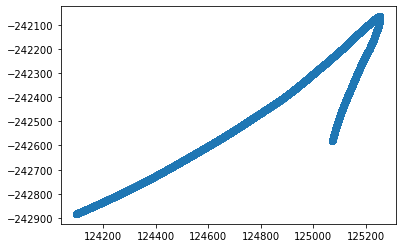

In [11]:
plt.scatter(gnssutm[0], gnssutm[1])

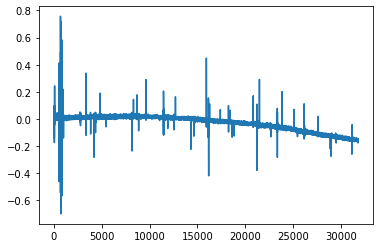

In [12]:
plt.plot(np.diff(gnssutm[0]))

In [13]:
gnssdayseconds[0:5]

array([28531.99999, 28532.99999, 28533.99999, 28534.99999, 28535.99999])

## Load  GEM2 data to be drift corrected

In [14]:
gem2inputfile = "/mnt/documents/JC2-2/P11-16092021/gem2/18092021/processed-survey/JC2-2-P11-ridge-gem2-531-channel-thickness.csv"

In [15]:
gem2data = pd.read_csv(gem2inputfile, low_memory = False)

In [16]:
gem2data

time   record_id   longitude   latitude   xc   yc  \
0     2021-09-18T16:26:09.593750           0         0.0        0.0  0.0  0.0   
1     2021-09-18T16:26:09.703125           1         0.0        0.0  0.0  0.0   
2     2021-09-18T16:26:09.796875           2         0.0        0.0  0.0  0.0   
3     2021-09-18T16:26:09.906250           3         0.0        0.0  0.0  0.0   
4            2021-09-18T16:26:10           4         0.0        0.0  0.0  0.0   
...                          ...         ...         ...        ...  ...  ...   
3357  2021-09-17T14:43:19.234375        3357         0.0        0.0  0.0  0.0   
3358  2021-09-17T14:43:19.328125        3358         0.0        0.0  0.0  0.0   
3359  2021-09-17T14:43:19.437500        3359         0.0        0.0  0.0  0.0   
3360  2021-09-17T14:43:19.531250        3360         0.0        0.0  0.0  0.0   
3361  2021-09-17T14:43:19.640625        3361         0.0        0.0  0.0  0.0   

      f450Hz_hcp_i   f450Hz_hcp_q   f1530Hz_hcp_i   f1530Hz_hcp_q  \
0            1.203          0.840           1.254           0.907   
1            1.411          0.818           1.219           0.902   
2            1.210          0.809           1.190           0.910   
3            0.494          0.807           1.326           0.918   
4            0.242          0.794           1.402           0.901   
...            ...            ...             ...             ...   
3357         0.834          0.728           0.754           0.739   
3358         0.719          0.740           0.708           0.740   
3359         1.029          0.771           0.756           0.748   
3360         2.204          0.752           0.850           0.745   
3361         0.984          0.784           0.921           0.746   

      f5310Hz_hcp_i   f5310Hz_hcp_q   f18330Hz_hcp_i  f18330Hz_hcp_q  \
0             0.956           0.890            0.892           0.881   
1             0.942           0.897            0.886           0.878   
2             0.934           0.899            0.885           0.883   
3             0.932           0.883            0.889           0.882   
4             0.934           0.879            0.891           0.876   
...             ...             ...              ...             ...   
3357          0.732           0.729            0.735           0.719   
3358          0.747           0.729            0.734           0.720   
3359          0.785           0.733            0.735           0.719   
3360          0.781           0.732            0.736           0.720   
3361          0.759           0.730            0.736           0.721   

       f63030Hz_hcp_i   f63030Hz_hcp_q  
0               0.875            0.883  
1               0.875            0.882  
2               0.876            0.883  
3               0.876            0.883  
4               0.875            0.883  
...               ...              ...  
3357            0.729            0.700  
3358            0.730            0.700  
3359            0.728            0.698  
3360            0.727            0.696  
3361            0.727            0.694  

[3362 rows x 16 columns]

In [17]:
gem2data.drop(gem2data[gem2data[" longitude"] == 0].index, inplace=True)
gem2data.drop(gem2data[gem2data[" latitude"] == 0].index, inplace=True)

In [18]:
gem2data

time   record_id   longitude   latitude   xc   yc  \
87    2021-09-18T14:26:02.359375          87  -17.685783  87.483627  0.0  0.0   
88    2021-09-18T14:26:02.468750          88  -17.685787  87.483627  0.0  0.0   
89    2021-09-18T14:26:02.562500          89  -17.685789  87.483627  0.0  0.0   
90    2021-09-18T14:26:02.671875          90  -17.685793  87.483627  0.0  0.0   
91    2021-09-18T14:26:02.765625          91  -17.685797  87.483627  0.0  0.0   
...                          ...         ...         ...        ...  ...  ...   
3350  2021-09-17T14:43:18.531250        3350  -17.704203  87.483391  0.0  0.0   
3351  2021-09-17T14:43:18.640625        3351  -17.704205  87.483391  0.0  0.0   
3352  2021-09-17T14:43:18.734375        3352  -17.704207  87.483391  0.0  0.0   
3353  2021-09-17T14:43:18.828125        3353  -17.704208  87.483391  0.0  0.0   
3354  2021-09-17T14:43:18.937500        3354  -17.704210  87.483391  0.0  0.0   

      f450Hz_hcp_i   f450Hz_hcp_q   f1530Hz_hcp_i   f1530Hz_hcp_q  \
87           0.825          0.783           1.246           0.928   
88           1.075          0.770           1.373           0.913   
89           1.078          0.770           1.431           0.927   
90           1.105          0.762           1.452           0.923   
91           0.570          0.780           1.483           0.907   
...            ...            ...             ...             ...   
3350         0.757          0.702           0.809           0.735   
3351         0.972          0.662           0.891           0.728   
3352         0.159          0.686           0.895           0.740   
3353         0.107          0.716           0.884           0.740   
3354         1.004          0.685           0.808           0.757   

      f5310Hz_hcp_i   f5310Hz_hcp_q   f18330Hz_hcp_i  f18330Hz_hcp_q  \
87            0.944           0.901            0.934           0.879   
88            0.930           0.898            0.929           0.879   
89            0.915           0.891            0.927           0.879   
90            0.916           0.898            0.927           0.880   
91            0.918           0.896            0.927           0.882   
...             ...             ...              ...             ...   
3350          0.756           0.727            0.736           0.719   
3351          0.752           0.732            0.735           0.719   
3352          0.753           0.733            0.738           0.721   
3353          0.759           0.733            0.741           0.723   
3354          0.736           0.729            0.738           0.722   

       f63030Hz_hcp_i   f63030Hz_hcp_q  
87              0.908            0.820  
88              0.907            0.821  
89              0.908            0.820  
90              0.909            0.818  
91              0.909            0.818  
...               ...              ...  
3350            0.727            0.699  
3351            0.727            0.698  
3352            0.727            0.696  
3353            0.727            0.697  
3354            0.727            0.700  

[2650 rows x 16 columns]

In [19]:
f1530hz_hcp_i = [float(zi) for zi in gem2data[" f1530Hz_hcp_i"].values]

In [20]:
gem2utm = thetransform.transform(gem2data[" latitude"].values, gem2data[" longitude"].values)

In [21]:
gem2easting = gem2utm[0]
gem2northing = gem2utm[1]

Text(0.5, 1.0, 'uncorrected drift track - local coordinates')

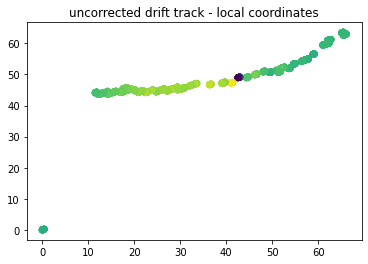

In [22]:
plt.scatter(gem2easting-np.min(gem2easting), gem2northing-min(gem2northing), c = f1530hz_hcp_i)
plt.title("uncorrected drift track - local coordinates")

In [23]:
gem2times = gem2data['time'].values
gem2dayseconds=[]
for thetime in gem2times:
    thisdate, thistime = thetime.split('T')
    #print(thistime)
    hour, minute, second = thistime.split(':')
    #print(len(thetime))
    #print(thetime)
    gem2dayseconds.append(((int(hour))*3600.0) + (int(minute) * 60.0) + float(second))
gem2dayseconds = np.array(gem2dayseconds)

In [24]:
gem2dayseconds = np.round(gem2dayseconds, 4)

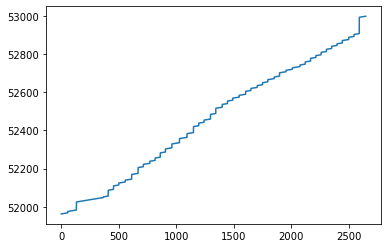

In [25]:
plt.plot(gem2dayseconds)

In [26]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, gem2dayseconds)

51962.3594
23430
24467


In [27]:
gnss_trimmedtime = np.array(np.squeeze(gnss_trimmedtime))

In [28]:
start

51962.3594

In [29]:
end

52998.9375

In [30]:
gnssdayseconds = np.array(gnssdayseconds)

In [31]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [32]:
trimmedtime[0]

51962.0

In [33]:
trimmedtime[-1]

52999.0

In [34]:
gem2dayseconds[0]

51962.3594

In [35]:
gem2dayseconds[-1]

52998.9375

In [36]:
gnssdayseconds[0]

28531.99999

In [37]:
timesteps = np.arange(trimmedtime.min()-0.5, trimmedtime.max()+0.5, 0.0001)
timesteps = np.round(timesteps, 4)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)
    

In [38]:
timesteps = np.round(timesteps, 4)

In [39]:
np.where(timesteps == gem2dayseconds[1000])

(array([3716250]),)

In [40]:
timesteps[9219]

51962.4219

In [41]:
gem2dayseconds[-1]

52998.9375

In [42]:
gnssdayseconds[-1]

60317.0

In [43]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in gem2dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])
    else:
        pass
        #print(thistimeindex[0])
        #print(thistime)

CPU times: user 14.6 s, sys: 597 µs, total: 14.6 s
Wall time: 14.6 s


In [44]:
len(timeindexes)

2650

In [45]:
len(gem2dayseconds)

2650

In [ ]:
gnss_gem2_match_eastings = interp_east[timeindexes]
gnss_gem2_match_northings = interp_north[timeindexes]

In [ ]:
plt.scatter(gnss_gem2_match_eastings, gnss_gem2_match_northings)

In [ ]:
gnss_gem2_match_eastings[0]

In [ ]:
gnss_gem2_match_northings[0]

In [ ]:
len(gnss_gem2_match_eastings)

In [ ]:
len(gem2easting)

In [ ]:
gnss_gem2_match_eastings = np.squeeze(gnss_gem2_match_eastings)
gnss_gem2_match_northings = np.squeeze(gnss_gem2_match_northings)

In [ ]:
gnss_gem2_match_eastings[0]

In [ ]:
gem2easting[0]

In [ ]:
local_gem2_east = gem2easting - gnss_gem2_match_eastings
local_gem2_north = gem2northing - gnss_gem2_match_northings

In [ ]:
local_gem2_east[0]

In [ ]:
local_gem2_north[0]

In [ ]:
world_gem2_east = local_gem2_east + gnss_gem2_match_eastings[0]
world_gem2_north = local_gem2_north + gnss_gem2_match_northings[0]

In [ ]:
world_gem2_east.size

In [ ]:
gnss_gem2_match_eastings[0]

In [ ]:
plt.scatter(local_gem2_east, local_gem2_north, c=f1530hz_hcp_i)

In [ ]:
gem2_header = """AeN JC2-2 2021 P11 GEM2 measurements
GEM2-531 electromagnetic induction sounder
18 September 2021
Adam Steer / Anca Cristea
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coodinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730

"""

In [ ]:
gem2_easting_df = pd.DataFrame({"easting": world_gem2_east})

In [ ]:
gem2out = gem2data.copy()

In [ ]:
gem2data.keys()

In [ ]:
gem2out.drop(columns = [" longitude", " latitude"], inplace=True)
gem2out.keys()

In [ ]:
gem2out.insert(2, "easting", world_gem2_east)

In [ ]:
gem2out.insert(3, "northing", world_gem2_north)

In [ ]:
gem2out.keys()

In [ ]:
gem2_output = "/mnt/documents/JC2-2/P11-16092021/gem2/18092021/GEM2data-driftcorrected-18092021.csv"

In [ ]:
with open(gem2_output, 'w') as outfile:
    outfile.write(gem2_header)
    

In [ ]:
gem2out.to_csv(gem2_output, index=False, mode='a')

## Load Magnaprobe data to be drift corrected

Using the Alaska Magnaprobe we need to add 8 hours to timestamps...

In [ ]:
magnaprobeinputfile = "/mnt/documents/JC2-2/P11-16092021/magnaprobe/180920201/NPI8.dat"


In [ ]:
mpcolumns = ["TIMESTAMP","RECORD","Counter","DepthCm","BattVolts","latitude_a","latitude_b","Longitude_a","Longitude_b","fix_quality","nmbr_satellites","HDOP","altitudeB","DepthVolts","LatitudeDDDDD","LongitudeDDDDD","month","dayofmonth","hourofday","minutes","seconds","microseconds"]

In [ ]:
mpdata = pd.read_csv(magnaprobeinputfile, skiprows=4, names = mpcolumns)

In [ ]:
mpdata

In [ ]:
mpdepths = mpdata["DepthCm"].values / 100
mprawtimes = mpdata["TIMESTAMP"].values
mprawtimes = mprawtimes
mprawtimes[0].split(' ')
mprawdays = [thistime.split(' ')[0] for thistime in mprawtimes]
mptimes = [thistime.split(' ')[1] for thistime in mprawtimes]
mpdays = [datetime.strptime(thisday, "%Y-%m-%d") for thisday in mprawdays]
mptimes = np.array(mptimes)

In [ ]:
weekdelta = timedelta(weeks=1024)

In [ ]:
mpdaysfixed = [day + weekdelta for day in mpdays]

In [ ]:
mptimes

In [ ]:
mp_dayseconds=[]
for thetime in mptimes:
    hour, minute, second = thetime.split(':')
    #print(len(thetime))
    #print(thetime)
    mp_dayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + float(second))

In [ ]:
mp_dayseconds = np.round(mp_dayseconds, 2)
mp_dayseconds

In [ ]:
gnssdayseconds

In [ ]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, mp_dayseconds)

In [ ]:
gnssdayseconds = np.array(gnssdayseconds)

In [ ]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [ ]:
timesteps = np.arange(trimmedtime.min()-0.01, trimmedtime.max()+0.01, 0.01)
timesteps = np.round(timesteps, 2)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)

In [ ]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in mp_dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])

In [ ]:
len(timeindexes)

In [ ]:
len(mp_dayseconds)

In [ ]:
gnss_mp_match_eastings = np.squeeze(interp_east[timeindexes])
gnss_mp_match_northings = np.squeeze(interp_north[timeindexes])

Now get geo-data from the magnaprobe organised

In [ ]:
mplatddd = mpdata["latitude_a"].values + (mpdata["latitude_b"].values / 60)
mplonddd = mpdata["Longitude_a"].values + (mpdata["Longitude_b"].values / 60)

In [ ]:
mputm = thetransform.transform(mplatddd, mplonddd)

In [ ]:
mpeasting = mputm[0]
mpnorthing = mputm[1]

In [ ]:
plt.scatter(mpeasting, mpnorthing, c = mpdata["DepthCm"])

Do the drift correction to local coordinates

In [ ]:
local_mp_east = mpeasting - gnss_mp_match_eastings
local_mp_north = mpnorthing - gnss_mp_match_northings

In [ ]:
len(mpeasting)

In [ ]:
len(gnss_mp_match_eastings)

Convert back to world coordinates

In [ ]:
world_mp_east = local_mp_east + gnss_gem2_match_eastings[0]
world_mp_north = local_mp_north + gnss_gem2_match_northings[0]

In [ ]:
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"])

Export data to CSV

In [ ]:
# first generate correct timestamps! Remembering the raw times are 1024 weeks out
mp_timefixed = []
i = 0
for thistime in mptimes:
    theday = datetime.strftime(mpdaysfixed[i],"%d-%m-%Y")
    thetimestamp = theday + "T" + thistime
    mp_timefixed.append(thetimestamp)
    i += 1

In [ ]:
mp_timefixed

In [ ]:
# Assemble a dataframe
mp_export = pd.DataFrame({"timestamp": mp_timefixed, 
                          "easting": world_mp_east, 
                          "northing": world_mp_north, 
                          "snowdepth": mpdata["DepthCm"]/100   })

In [ ]:
mp_output = "/mnt/documents/JC2-2/P11-16092021/magnaprobe/17092021/MPdata-driftcorrected-datefixed.csv"

In [ ]:
mp_header = """AeN JC2-2 P11 Magnaprobe measurements
Snowhydro Magnaprobe NPI-1
17 September 2021
Adam Steer / Anca Cristea
Time corrected: adding 1024 weeks to timestamps accounting for the 2019 GPS week rollover
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coordinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for date and drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730


"""

In [ ]:
with open(mp_output, 'w') as outfile:
    outfile.write(mp_header)
    

In [ ]:
mp_export.to_csv(mp_output, index=False, mode='a')

## Plot GEM2 and magnaprobe data together

In [ ]:
plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i, cmap = "Blues", s=200)
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"]/100)

In [ ]:
plt.plot(mpdata["DepthCm"]/100)

## Load camera centers to be drift corrected

This is tricky - drone flights occurred the day before the ice station started. So we use a different GPS station to get local coordinates.

In [ ]:
cameracentrefile = "/mnt/documents/ANAFI-USA/jc2-2/15092021-p11-prestation/cameracentres.csv"

In [ ]:
cameradata = pd.read_csv(cameracentrefile)

In [ ]:
cameradata.drop(cameradata[cameradata["GPSLongitude"] == 0].index, inplace=True)
cameradata.drop(cameradata[cameradata["GPSLatitude"] == 0].index, inplace=True)

In [ ]:
camerautm = thetransform.transform(cameradata["GPSLatitude"].values, cameradata["GPSLongitude"].values)

In [ ]:
cameraeasting = camerautm[0]
cameranorthing = camerautm[1]

In [ ]:
plt.scatter(cameraeasting, cameranorthing)

In [ ]:
cameradata

In [ ]:
cam_utm = thetransform.transform(cameradata["GPSLatitude"], cameradata["GPSLongitude"])

In [ ]:
cam_utm[0][0]

In [ ]:
cam_rawtimes = cameradata["DateTimeOriginal"].values
cam_rawtimes = cam_rawtimes
cam_rawtimes[0].split(' ')
cam_rawdays = [thistime.split(' ')[0] for thistime in cam_rawtimes]
cam_times = [thistime.split(' ')[1] for thistime in cam_rawtimes]
cam_days = [datetime.strptime(thisday, "%Y:%m:%d") for thisday in cam_rawdays]
cam_times = np.array(cam_times)

In [ ]:
subseconds = [x / 10**len(str(x)) for x in cameradata["SubSecTimeOriginal"]]
subseconds[0:5]

In [ ]:
cam_dayseconds=[]
i = 0
for thetime in cam_times:
    hour, minute, second = thetime.split(':')
    #print(len(thetime))
    #print(thetime)
    cam_dayseconds.append((int(int(hour)-2)*3600.0) + (int(minute) * 60.0) + float(subseconds[i]))
    i += 1

In [ ]:
cam_dayseconds[0]

In [ ]:
## read the relevant GPS file

clons, clats, ctimes = readbasegps("/mnt/documents/JC2-2/P11-16092021/garmin/station-fixed/Current.gpx")

In [ ]:
clats

In [ ]:
themonths = [thetime.month for thetime in ctimes]
thedays = [thetime.day for thetime in ctimes]

In [ ]:
themonths = np.array(themonths)
thedays = np.array(thedays)

In [ ]:
thisday = np.where((themonths[:] == 9) & (thedays == 15))

In [ ]:
thisday

In [ ]:

clats[thisday]
ctimes[thisday]

In [ ]:
the_clats = clats[thisday]
the_clons = clons[thisday]
the_ctimes = ctimes[thisday]


In [ ]:
len(the_ctimes)

In [ ]:
the_ctimes[0]

In [ ]:
the_ctimes[-1]

In [ ]:
gnssdayseconds=[]
for thetime in the_ctimes:
    hour = thetime.hour
    minute = thetime.minute
    second = thetime.second
    millisecond = float(this.microsecond) / 1000000
    gnssdayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + int(second) + float(millisecond))
gnssdayseconds = np.array(gnssdayseconds)

In [ ]:
the_clats

In [ ]:
gnssutm = thetransform.transform(the_clats, the_clons)
gnssutm = np.array(gnssutm)

In [ ]:
gnssutm[0]

In [ ]:
gnssutm[0]

In [ ]:
cam_utm[0]

In [ ]:
gnssdayseconds[0]

In [ ]:
gnssdayseconds[-1]

In [ ]:
len(gnssdayseconds)

In [ ]:
len(cam_dayseconds)

In [ ]:
## these are from PhD work in 2015
def trim_timeseries(t1, t2):
#trim a long timeseries to match a shorter one.
#t1 is the long series, t2 is the short sries
#returns a set of indices to apply to the longer
#timeseries dataset
    start = t2[0]
    end = t2[-1]
    
    print(start)
    print(end)
    
    lowidx = np.where(t1 < start)
    
    print(lowidx)
    
    highidx = np.where(t1 > end)
    
    print(lowidx[0][-1])
    print(highidx[0][0])
    
    the_inds = np.arange(lowidx[0][-1], highidx[0][0]+1,1)
    
    
    #idx = (t1>=start)*(t1=<end)
    
    #the_inds = np.where(idx)
    #if t1[the_inds[0]] > start:
    #    inds2 = np.where(t1)
        
        
    return np.asarray(the_inds), start, end

In [ ]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, cam_dayseconds)

In [ ]:
len(gnss_trimmedtime)

In [ ]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [ ]:
trimmedeast[0]

In [ ]:
gnssutm[0][0:5]

In [ ]:
cameraeasting[0]

In [ ]:
min(cam_dayseconds)

In [ ]:
max(cam_dayseconds)

In [ ]:
min(gnssdayseconds)

In [ ]:
max(gnssdayseconds)

In [ ]:
timesteps = np.arange(trimmedtime.min()-0.5, trimmedtime.max()+0.5, 0.001)
timesteps = np.round(timesteps, 3)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)

In [ ]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in cam_dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])
    else:
        print(thistimeindex[0])

In [ ]:
gnss_cam_match_eastings = np.squeeze(interp_east[timeindexes])
gnss_cam_match_northings = np.squeeze(interp_north[timeindexes])

In [ ]:
local_cam_east = cameraeasting - gnss_cam_match_eastings
local_cam_north = cameranorthing - gnss_cam_match_northings

In [ ]:
local_cam_east[0]

In [ ]:
local_cam_north[0]

In [ ]:
gnss_cam_match_northings[0] - gnss_cam_match_northings[-1]

In [ ]:
plt.scatter(gnss_cam_match_eastings, gnss_cam_match_northings)
plt.scatter(cameraeasting[-1], cameranorthing[-1])

In [ ]:
cameraeasting[0]

In [ ]:
gem2easting[0]

In [ ]:
cameranorthing[0]

In [ ]:
gem2northing[0]

In [ ]:
local_gem2_east[0]

In [ ]:
local_mp_east[0]

In [ ]:
plt.scatter(local_cam_east, local_cam_north)

In [ ]:
gnss_gem2_match_eastings[0]

In [ ]:
local_gem2_east[0]

In [ ]:
world_cam_east = local_cam_east + gnss_cam_match_eastings[0]
world_cam_north = local_cam_north + gnss_cam_match_northings[0]

In [ ]:
world_cam_east[0]

In [ ]:
world_gem2_east[0]

In [ ]:
fig = plt.figure(figsize=(20,20))

#plt.scatter(gnssutm[0],gnssutm[1], s = 10, label = 'day 1 drift track')
#plt.scatter(gnss_cam_match_eastings, gnss_cam_match_northings, label = "camera match track")
#plt.scatter(gnss_mp_match_eastings, gnss_mp_match_northings)
#plt.scatter(gnss_gem2_match_eastings, gnss_gem2_match_northings)

plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i, cmap = "Blues", s=200, label = "GEM2")
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"]/100, label = "Magnaprobe")
plt.scatter(world_cam_east, world_cam_north, c = cameradata["AboveGroundAltitude"], label = "camera centres", cmap="Greens")
plt.legend()
plt.grid()
ax = plt.gca()
ax.set_aspect("equal")
plt.savefig("/mnt/documents/Q2/AeNP6-09052021/driftracks.png")

In [ ]:
backtolatlon = pyproj.transformer.Transformer.from_proj(3413,4326)

In [ ]:
cam_latlon = backtolatlon.transform(world_cam_east, world_cam_north)

In [ ]:
cam_out = cameradata.copy()

In [ ]:
cam_out["GPSLatitude"] = cam_latlon[0]

In [ ]:
cam_out["GPSLongitude"] = cam_latlon[1]

In [ ]:
mp_output_exiftool = "/mnt/documents/ANAFI-USA/jc2-2/15092021-p11-prestation/driftcorrected-for-exiftool.csv"

In [ ]:
cam_out.to_csv(mp_output_exiftool, index=False)

In [ ]:
cam_out['GPSLatitude'][0] - cameradata["GPSLatitude"][0]

In [ ]:
cam_out['GPSLatitude'][0]

cam_o

In [ ]:
cam_out_hag = cam_out.copy()

In [ ]:
cam_out_hag["GPSAltitude"] = cam_out_hag["AboveGroundAltitude"]

In [ ]:
cam_out_hag.drop(columns = ["AboveGroundAltitude"], inplace = True)

In [ ]:
cam_output_exiftool_hag = "/mnt/documents/ANAFI-USA/jc2-2/15092021-p11-prestation/driftcorrected-for-exiftool-HAG.csv"

In [ ]:
cam_out_hag.to_csv(cam_output_exiftool_hag, index=False)